# Evaluate Already Trained Models for Comparison

## Loading Models


In [ ]:
from fundemental_classes.model_related.glm_model import GLMModel

deletion_model = GLMModel(
    "./dna_bert_final_indel",
    "simulated_sequences_distance=5/new_augumented_sequence_size10000_length150_deletions0.2_nodeletionseq0.05.fasta",
    force_retrain=False,
    include_deletions=True
)

baseline_model = GLMModel(
    "./dna_bert_final_baseline",
    "simulated_baseline_sequences_distance=5/new_augumented_sequence_size10000_length150_deletions0_nodeletionseq0.05.fasta",
    force_retrain=False,
    include_deletions=False
)

## Evaluation of each model with respect to a test dataset

### Creating Evaluation

In [ ]:
from fundemental_classes.model_related.model_eval import ModelEvaluator

evaluator = ModelEvaluator(baseline_model, deletion_model)

evaluator.evaluate_dataset(
    test_fasta_path="test_baseline_data_distance=5/new_augumented_sequence_size10000_length150_deletions0.2_nodeletionseq0.05.fasta",
    model_type='baseline',
    max_sequences=None
)

evaluator.evaluate_dataset(
    test_fasta_path="test_data_distance=5/new_augumented_sequence_size10000_length150_deletions0_nodeletionseq0.05.fasta",
    model_type='deletion',
    max_sequences=None
)

evaluator.export_results("results/evaluation_results.json")
print("✓ Evaluation complete and saved")

### Loading Evaluation

In [1]:
from fundemental_classes.model_related.model_eval import ModelEvaluator

evaluator = ModelEvaluator.load_results("results/evaluation_results.json")
print("Results loaded from JSON")

/home/giokepa/.virtualenvs/Sysgen-GLM-for-Indels/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Results loaded from results/evaluation_results.json
✓ Results loaded from JSON


## Visualization of Evaluation Results

**Per-position cross-entropy:**

$$
H(pos) = -\log P(x_{true} \mid context)
$$

**Parameters:**
- $x_{true}$: The true character at position $pos$ in the sequence
- $P(x_{true} \mid context)$: The model's predicted probability for $x_{true}$ given the surrounding context
- $context$: All other positions in the sequence (used by the masked language model)

**Average cross-entropy for a sequence:**

$$
H_{avg} = -\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid context_i)
$$

**Parameters:**
- $N$: Total number of valid positions in the sequence
- $x_i$: True character at position $i$
- $P(x_i \mid context_i)$: Model's predicted probability for $x_i$

**Interpretation:**
Cross-entropy measures the average number of bits needed to encode the true sequence using the model's predicted probability distribution. Lower values indicate better model performance.

---

## Perplexity

**Formula:**

$$
\text{Perplexity} = \exp(H_{avg}) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid context_i)\right)
$$

**Alternative formulation (geometric mean):**

$$
\text{Perplexity} = \left(\prod_{i=1}^{N} P(x_i \mid context_i)\right)^{-1/N}
$$

**Parameters:**
- $H_{avg}$: Average cross-entropy of the sequence
- $P(x_i \mid context_i)$: Model's predicted probability for character at position $i$
- $N$: Number of valid positions

**Interpretation:**
Perplexity represents the effective "branching factor" or average number of equally likely choices the model faces at each position. For DNA sequences with 4 possible bases (A, C, G, T), random guessing would yield a perplexity of 4. Lower perplexity indicates better model performance.

---

## Statistical Significance Tests

### 1. Paired t-Test

**Purpose:** Tests whether the mean difference between paired samples is significantly different from zero [web:11][web:12].

**Test statistic:**

$$
t = \frac{\bar{d}}{s_d / \sqrt{n}}
$$

**Parameters:**
- $\bar{d}$: Mean of the differences between paired observations
- $s_d$: Standard deviation of the differences
- $n$: Number of pairs
- Degrees of freedom: $df = n - 1$

**Assumptions:**
1. Paired observations are independent
2. Differences between pairs are approximately normally distributed
3. Data is measured on a continuous scale

**Null Hypothesis ($H_0$):** The mean difference between paired observations is zero

**Interpretation:** If $p < 0.05$, we reject the null hypothesis and conclude there is a statistically significant difference between the two models.

---

### 2. Wilcoxon Signed-Rank Test

**Purpose:** Non-parametric alternative to paired t-test; tests whether the median difference between paired samples is zero.

**Test statistic:**

$$
W = \sum_{i=1}^{n} \text{sgn}(x_i) \cdot R_i
$$

**Parameters:**
- $x_i$: Difference between paired observations at position $i$
- $\text{sgn}(x_i)$: Sign function (+1 if $x_i > 0$, -1 if $x_i < 0$)
- $R_i$: Rank of the absolute difference $|x_i|$ (smallest absolute difference gets rank 1)
- $n$: Number of non-zero differences

**Assumptions:**
1. Paired observations are independent
2. Differences are measured on at least an ordinal scale
3. Distribution of differences is symmetric around the median
4. **Does NOT require normality** (advantage over t-test)

**Null Hypothesis ($H_0$):** The median difference between paired observations is zero

**Interpretation:** If $p < 0.05$, there is a statistically significant difference between models. This test is more robust to outliers and non-normal distributions than the paired t-test.

---

### 3. Mann-Whitney U Test

**Purpose:** Non-parametric test for comparing two independent samples; tests whether distributions differ.

**Test statistic:**

$$
U = n_1 n_2 + \frac{n_1(n_1 + 1)}{2} - R_1
$$

**Parameters:**
- $n_1$: Number of observations in sample 1 (baseline model)
- $n_2$: Number of observations in sample 2 (deletion model)
- $R_1$: Sum of ranks for sample 1
- The smaller of $U$ and $U' = n_1 n_2 - U$ is typically used

**Assumptions:**
1. Observations are independent
2. Data is at least ordinal
3. **Does NOT require normality**

**Null Hypothesis ($H_0$):** The two samples come from the same distribution

**Interpretation:** If $p < 0.05$, the distributions of cross-entropy values differ significantly between the two models. This test treats samples as independent (unlike paired tests).

---

## Effect Size

### Cohen's d

**Purpose:** Measures the standardized difference between two means; indicates practical significance.

**Formula:**

$$
d = \frac{\bar{x}_1 - \bar{x}_2}{s_{pooled}}
$$

where the pooled standard deviation is:

$$
s_{pooled} = \sqrt{\frac{s_1^2 + s_2^2}{2}}
$$

**Parameters:**
- $\bar{x}_1$: Mean of baseline model cross-entropy
- $\bar{x}_2$: Mean of deletion model cross-entropy
- $s_1$: Standard deviation of baseline model
- $s_2$: Standard deviation of deletion model

**Interpretation guidelines:**
- $|d| < 0.2$: Negligible effect
- $0.2 \leq |d| < 0.5$: Small effect
- $0.5 \leq |d| < 0.8$: Medium effect
- $|d| \geq 0.8$: Large effect

**Note:** The sign indicates direction (positive: baseline > deletion; negative: deletion > baseline)

---

## 95% Confidence Interval for Mean Difference

**Formula:**

$$
CI_{95\%} = (\bar{x}_1 - \bar{x}_2) \pm 1.96 \cdot SE_{diff}
$$

where:

$$
SE_{diff} = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}
$$

**Parameters:**
- $\bar{x}_1 - \bar{x}_2$: Observed difference in means
- $SE_{diff}$: Standard error of the difference
- $s_1, s_2$: Standard deviations of the two samples
- $n_1, n_2$: Sample sizes
- 1.96: Critical value for 95% confidence (from standard normal distribution)

**Interpretation:** We are 95% confident that the true difference in mean cross-entropy between models lies within this interval. If the interval does not contain zero, the difference is statistically significant at $\alpha = 0.05$.

---

## Test Selection Guide

| Scenario | Recommended Test | Reason |
|----------|-----------------|---------|
| Same sequences tested on both models, normal differences | Paired t-test | Most powerful parametric test for paired data |
| Same sequences tested on both models, non-normal differences or outliers | Wilcoxon signed-rank | Robust non-parametric alternative |
| Different sequences for each model | Mann-Whitney U | Handles independent samples |
| Supplement any test | Cohen's d | Quantifies practical significance beyond p-values |

**Note:** Statistical significance ($p < 0.05$) indicates the difference is unlikely due to chance, while effect size (Cohen's d) indicates whether the difference is practically meaningful.



STATISTICAL COMPARISON (MOTIF-ONLY)

Paired t-test (Motif-only):
  t-statistic: 108.5983
  p-value: 0.000000e+00
  Significant (α=0.05): True

Wilcoxon signed-rank test (Motif-only):
  W-statistic: 3532700.0000
  p-value: 0.000000e+00
  Significant (α=0.05): True

Effect Size (Cohen's d): 1.5120
  Interpretation: large

4-NUCLEOTIDE COMPARISON (Fair Comparison)

Paired t-test (4-nucleotide):
  t-statistic: 108.5983
  p-value: 0.000000e+00
  Significant (α=0.05): True

Wilcoxon signed-rank test (4-nucleotide):
  W-statistic: 3532700.0000
  p-value: 0.000000e+00
  Significant (α=0.05): True

Effect Size (Cohen's d): 1.5120
  Interpretation: large
Boxplots saved to: results/boxplots.png


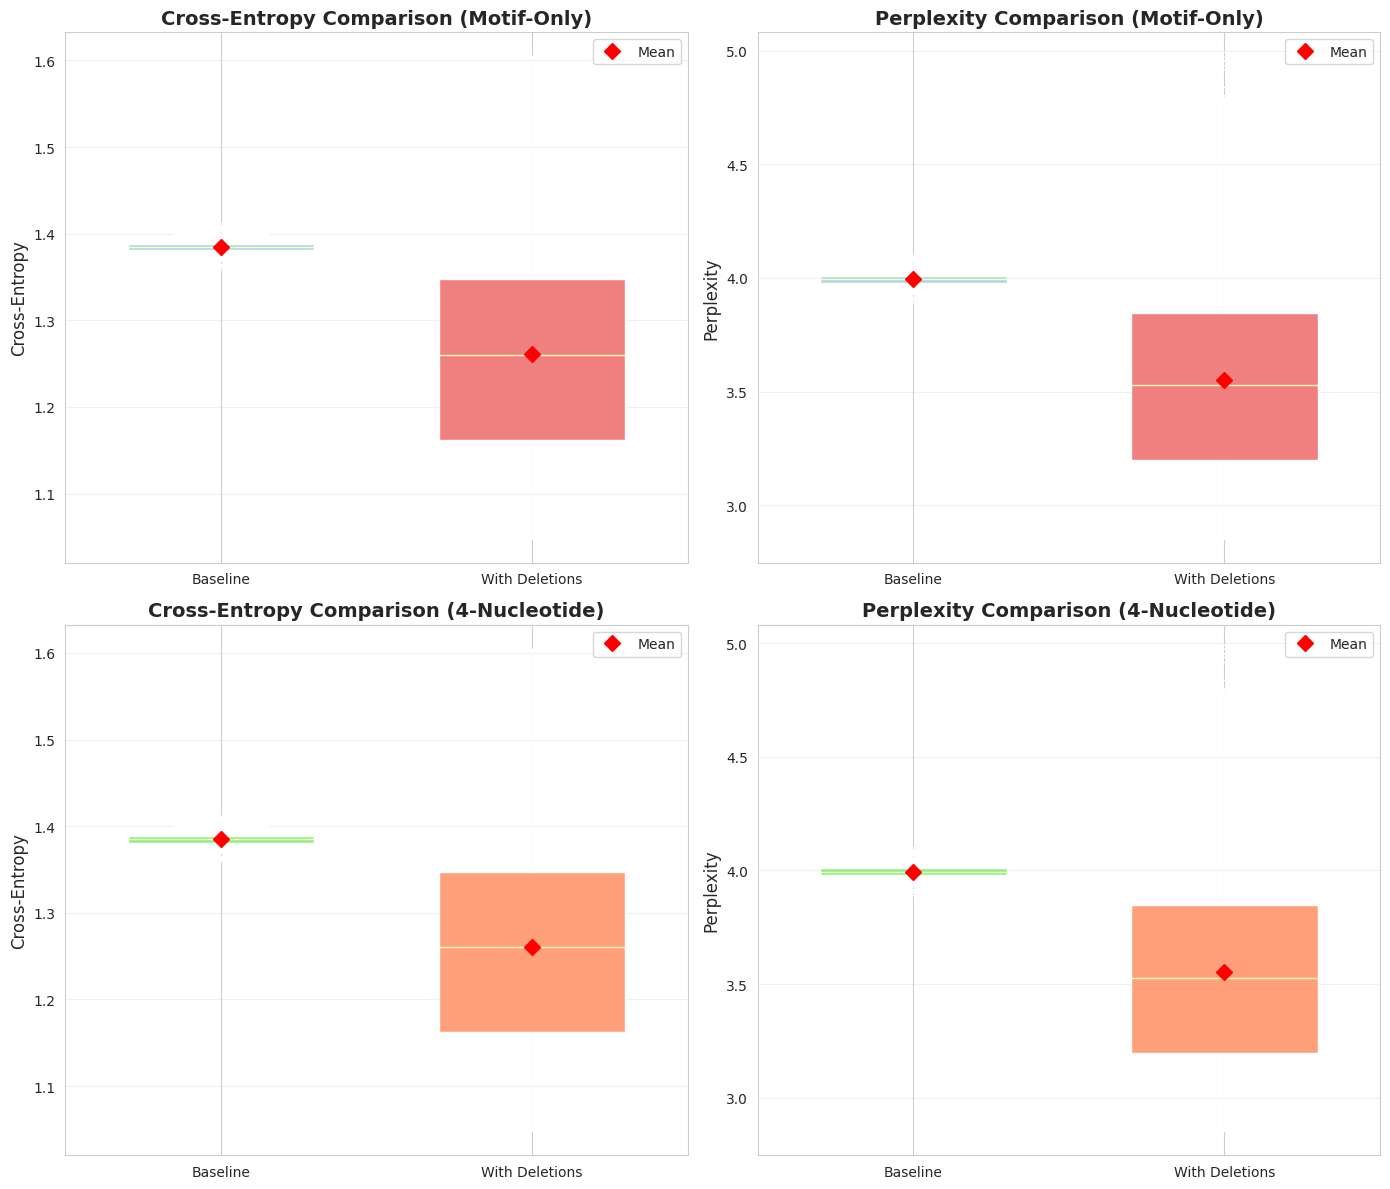

/mnt/c/Users/gioke/PycharmProjects/Sysgen-GLM-for-Indels/fundemental_classes/visualization/eval_plotter.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_motif, x='model', y='cross_entropy', ax=ax3,
/mnt/c/Users/gioke/PycharmProjects/Sysgen-GLM-for-Indels/fundemental_classes/visualization/eval_plotter.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Baseline', 'With Deletions'])


Distribution plots saved to: results/distributions.png


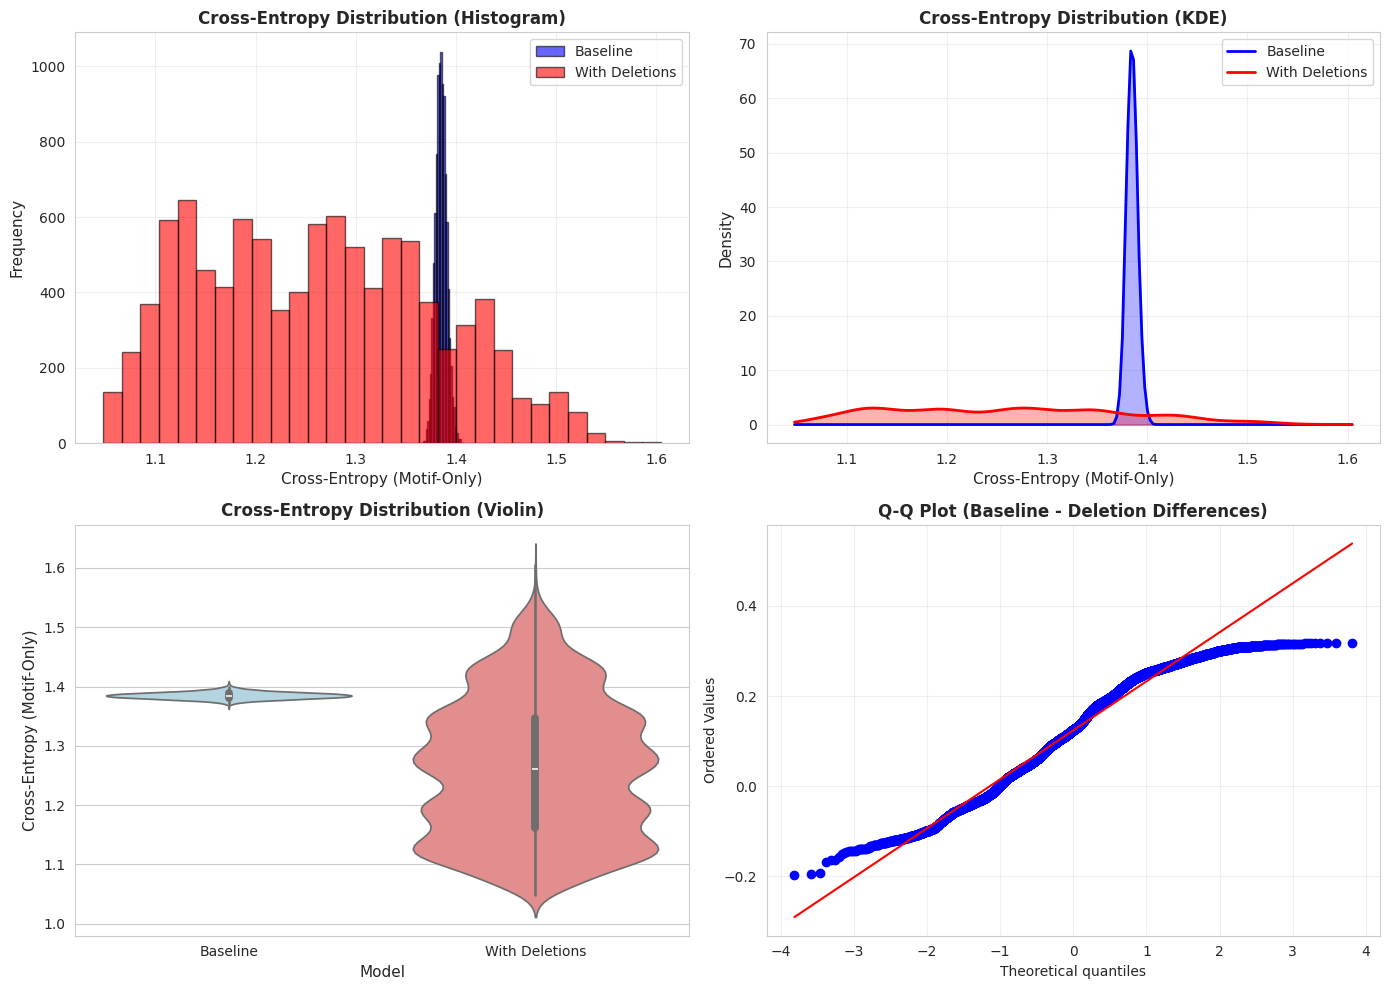

Scatter plot saved to: results/scatter_comparison.png


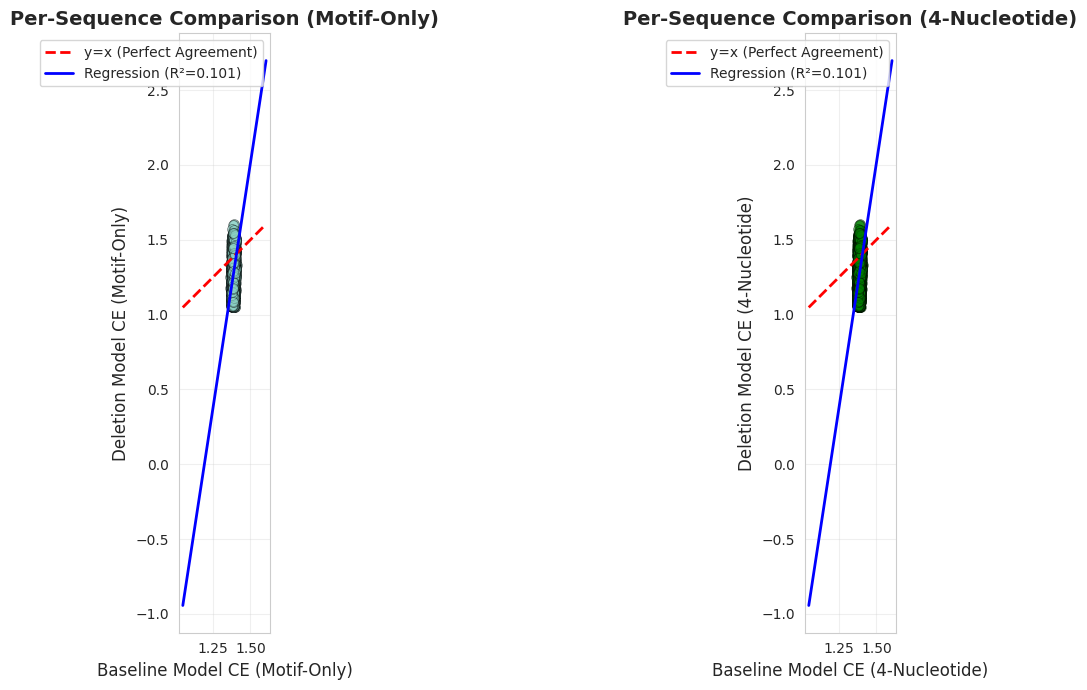

/mnt/c/Users/gioke/PycharmProjects/Sysgen-GLM-for-Indels/fundemental_classes/visualization/eval_plotter.py:342: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_motif, x='model', y='cross_entropy', ax=ax6,
/mnt/c/Users/gioke/PycharmProjects/Sysgen-GLM-for-Indels/fundemental_classes/visualization/eval_plotter.py:347: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_xticklabels(['Baseline', 'Deletion'])


Summary figure saved to: results/summary_figure.png


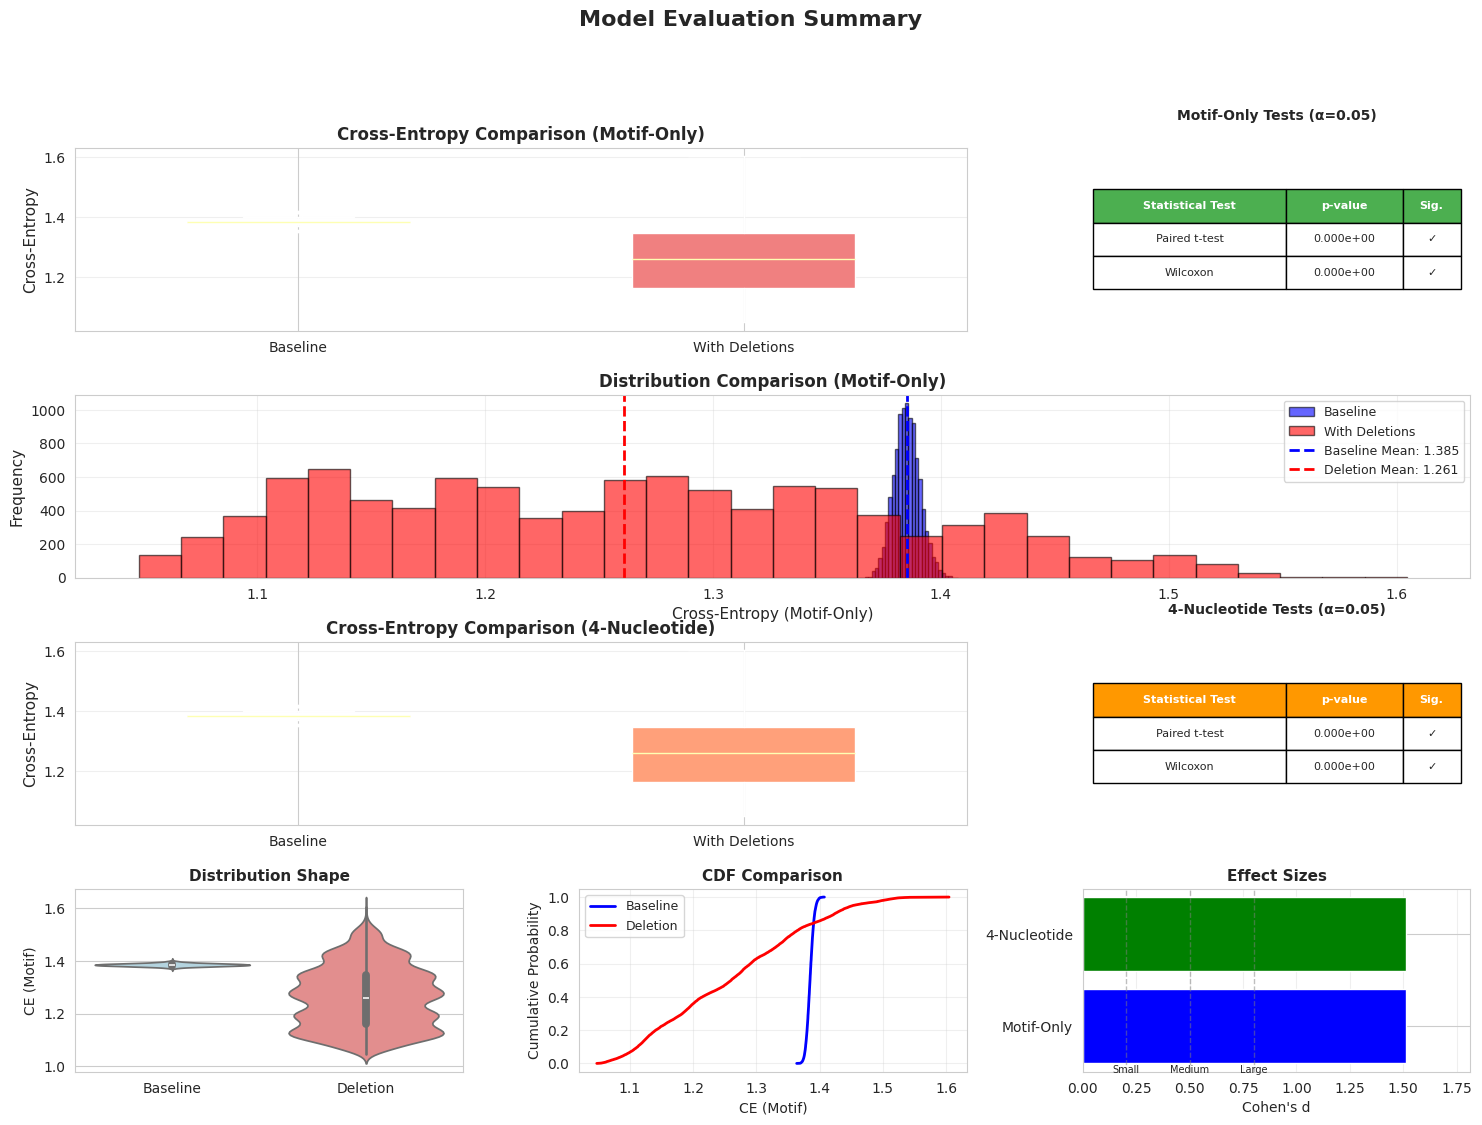

✓ All visualizations complete!


In [2]:
from fundemental_classes.visualization.eval_plotter import EvaluationVisualizer
comparison_results = evaluator.compare_models()

viz = EvaluationVisualizer(evaluator)

viz.plot_boxplots(save_path="results/boxplots.png")
viz.plot_distributions(save_path="results/distributions.png")
viz.plot_scatter_comparison(save_path="results/scatter_comparison.png")
viz.plot_summary_figure(comparison_results, save_path="results/summary_figure.png")

print("✓ All visualizations complete!")